# Over dit document
In dit document wordt een CRISP-DM cycles doorlopen, welke vervolgens een dataproduct (visualisaties) op zal leveren. Tot slot wordt er een conclusie getrokken en advies gegeven. 

# Business understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet. 


Voor een als er een voorspelling wordt gemaakt: 

Daarbij zou een visualisatie van een voorspelling meer inzicht brengen in hoe de total error mogelijk zal veranderen per jaar. Dit zou kunnen resulteren in toekomstige plannen voor het standaardiseren van de HbA1c meetmethoden.

# Data understanding
Welke databronnen zijn gegeven en in welk formaat:
Een excel bestand genaamd: Complete-dataset-FINAL.xlsx
##### note
Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn.

Hoe groot zijn deze databronnen:
355 kB

-4685 rijen

-12 kolommen


Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).

# Data preparation



In [1]:
# importeren van alle functies en het lezen van het databestand.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px
import cufflinks as cf
import numpy as np
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from sklearn.cluster import KMeans

df = pd.read_excel("Complete-dataset-FINAL.xlsx")

In [2]:
df["Bias"] = df["Bias"].replace("-", np.nan)
df["Bias"] = pd.to_numeric(df["Bias"])

df["Mean"] = df["Mean"].replace("-", np.nan)
df["Mean"] = pd.to_numeric(df["Mean"])

df["CV"] = df["CV"].replace("-", np.nan)
df["CV"] = df["CV"].replace(" ", np.nan)
df["CV"] = pd.to_numeric(df["CV"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          4684 non-null   object 
 1   N (no. labs)         4684 non-null   object 
 2   Mean                 4602 non-null   float64
 3   Bias                 4058 non-null   float64
 4   CV                   4584 non-null   float64
 5   Sample               4684 non-null   object 
 6   Reference Value      4656 non-null   float64
 7   Year                 4684 non-null   int64  
 8   Source (CAP/EurA1c)  4684 non-null   object 
 9   Type (Fresh/frozen)  4684 non-null   object 
 10  Manufacturer         4684 non-null   object 
 11  Total Error          4684 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 439.2+ KB


# Data groeperen
Wij groeperen de data zodat wij de methodes netjes bij elkaar hebben staan. Hierdoor kunnen wij visualisaties op basis van methode maken.

In [3]:
df2 = df[["Method name", "Year", "CV"]]

df3 = df2.groupby(["Method name","Year"]).mean()
df3 = df3.reset_index()
# df3 = df3.set_index("Method name")

df3

,Method name,Year,CV
0,A1cNOW,2006,7.377778
1,A1cNOW,2007,6.616667
2,A1cNOW,2008,6.250000
3,A1cNOW,2009,6.100000
4,A1cNOW,2010,4.883333
...,...,...,...
586,Vitros 5.1 FS. 4600. 5600,2018,2.573333
587,Vitros 5.1 FS. 4600. 5600,2019,3.064706
588,Vitros 5.1 FS. 4600. 5600,2020,2.750000
589,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,2020,2.650000


In [4]:
# Verwijder methodes die maar 1 keer voorkomen
method_occurance = df3["Method name"].value_counts()
less_than_one = method_occurance[method_occurance <= 1].index
dfFiltered = df3[~df3["Method name"].isin(less_than_one)]

# Filter de dataset op dat deze 2021 bevat
has_2021 = dfFiltered.groupby(["Method name"])['Year'].max()[lambda x: x != 2021].keys()
dfFiltered = dfFiltered[~dfFiltered["Method name"].isin(has_2021)]

dfFiltered

,Method name,Year,CV
9,Abbott Alinity ci series,2019,1.260000
10,Abbott Alinity ci series,2020,1.686667
11,Abbott Alinity ci series,2021,1.606667
36,Abbott Architect c System,2011,4.400000
37,Abbott Architect c System,2012,3.766667
...,...,...,...
568,Trinity Biotech Premier Hb9210 HPLC,2019,2.000000
569,Trinity Biotech Premier Hb9210 HPLC,2020,2.126667
570,Trinity Biotech Premier Hb9210 HPLC,2021,1.953333
589,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,2020,2.650000


# Modelling

Er is gekozen voor een lijngrafiek, omdat dit de duidelijkste manier is om de trend over de jaren weer te geven. Vanwege het relatief hoge aantal methodes is erin eerste instantie voor gekozen om een dropdownmenu van grafieken te maken per methode in plaats van ze allemaal in één grafiek te zetten. Dit zou anders te onoverzichtelijk zijn geworden. Er is wel een grafiek met het gemiddelde van alle methodes gemaakt. Dit kan gebruikt worden om per methode te vergelijken hoe de trend is vergeleken met het gemiddelde, maar heeft op zichzelf geen waarde.

Voor het voorspellende aspect op deze dataset is een regressieplot gebruikt. Ook hier zijn de grafieken weer per methode gescheiden voor overzichtelijkheid. Hier is vervolgens op doorgewerkt om de voorspelling voor het volgende jaar(2022) te maken. Vervolgens zijn de lijngrafiek, de voorspellende lijn en de ondersteunende data voor de voorspellingen gecombineerd in één overzicht, wederom gescheiden per methode.

In [5]:
# Realiseren: laat de lijngrafieken zien die bij een specifieke manufacturer horen.
def lijngrafiek(method):
    filteredDf = dfFiltered[dfFiltered["Method name"]== method]
    sns.relplot(data=dfFiltered, x="Year", y="CV", hue=filteredDf["Method name"], kind="line")

In [6]:
# Per Methode
interact(lijngrafiek, method = dfFiltered["Method name"].unique())

interactive(children=(Dropdown(description='method', options=('Abbott Alinity ci series', 'Abbott Architect c …

<function __main__.lijngrafiek(method)>

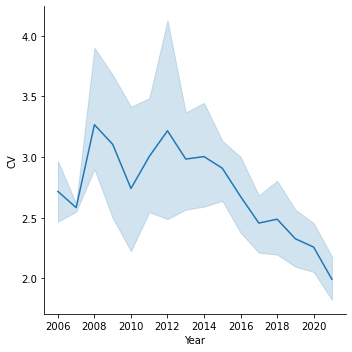

In [7]:
# Algemeen
sns.relplot(data=dfFiltered, x="Year", y="CV", kind="line")

In [8]:
# regressievergelijking waarop kan worden voorspeld.
def regressie(method):
    regDf = dfFiltered[dfFiltered["Method name"]== method]
    sns.regplot(data=regDf, x="Year", y="CV")

In [9]:
interact(regressie, method = dfFiltered['Method name'].unique())

interactive(children=(Dropdown(description='method', options=('Abbott Alinity ci series', 'Abbott Architect c …

<function __main__.regressie(method)>

In [10]:
import statsmodels.api as sm
def predict2022(method):
    # tempdf = dfFiltered[dfFiltered["Method name"]== method].dropna()
    tempdf = df2[df2["Method name"]== method].dropna()
    X = tempdf["Year"]
    Y = tempdf["CV"]

    # Fit and make the predictions by the model
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X)

    preddf = pd.DataFrame(predictions, columns=['CV'])
    preddf['Method name'] = method
    preddf['Year'] = "2022"
    preddf = preddf.groupby('Year').mean().reset_index()
    preddf["CV"].dropna()

    # Print out the statistics
    # return model.summary()

    regDf = pd.concat([tempdf,preddf])

    year = regDf['Year'].astype(int)
    sns.lineplot(x = 'Year', y = 'CV', data = regDf)
    sns.lineplot(x = 'Year', y = 'CV', data = regDf[(year >= 2021) & (year <= 2022)], color= 'lime')


    return model.summary()




In [11]:
interact(predict2022, method = dfFiltered['Method name'].unique())

interactive(children=(Dropdown(description='method', options=('Abbott Alinity ci series', 'Abbott Architect c …

<function __main__.predict2022(method)>

# Evaluation

Naar aanleiding van feedback is gebleken dat omrekening van de Europese data naar de Amerikaanse eenheden niet geheel juist is verlopen. Desondanks is er in deze grafieken wel gebruik gemaakt van de gecombineerde dataset. Verder zijn er twijfels over de waarde van voorspellingen op dit gebied. Niet alleen is de data beperkt, de accuraatheid van de meetmethodes wordt jaarlijks gemeten door de instanties van wie wij deze data hebben ontvangen. De metingen voor 2022 zijn al gedaan en zelfs al was dit niet het geval, vermoeden we dat ziekenhuizen liever metingen dan voorspellingen gebruiken. Wij adviseren daarom ook om erg voorzichtig te zijn met het gebruik van deze voorspellingen en per methode goed te kijken hoeveel datapunten er zijn meegenomen.